# MiniVGG

# Importamos las librerias


In [20]:
import os
import random
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt

# Si es que tenemos GPU con CUDA

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


# Dataset

In [ ]:

# Ruta a tu dataset
data_dir = "./imagewoof2"

# Transformaciones
IMG_SIZE = 256 #128

transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),      # esto es del data augmentation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),   # esto es del data augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

transform_val = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Dataset y DataLoader
train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=transform_train)
val_dataset = datasets.ImageFolder(root=f"{data_dir}/val", transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Clases detectadas: {train_dataset.classes}")
print(f"Número de imágenes de entrenamiento: {len(train_dataset)}")
print(f"Número de imágenes de validación: {len(val_dataset)}")

Clases detectadas: ['n02086240', 'n02087394', 'n02088364', 'n02089973', 'n02093754', 'n02096294', 'n02099601', 'n02105641', 'n02111889', 'n02115641']
Número de imágenes de entrenamiento: 9025
Número de imágenes de validación: 3929


# Visualizar las imagenes del Dataset 

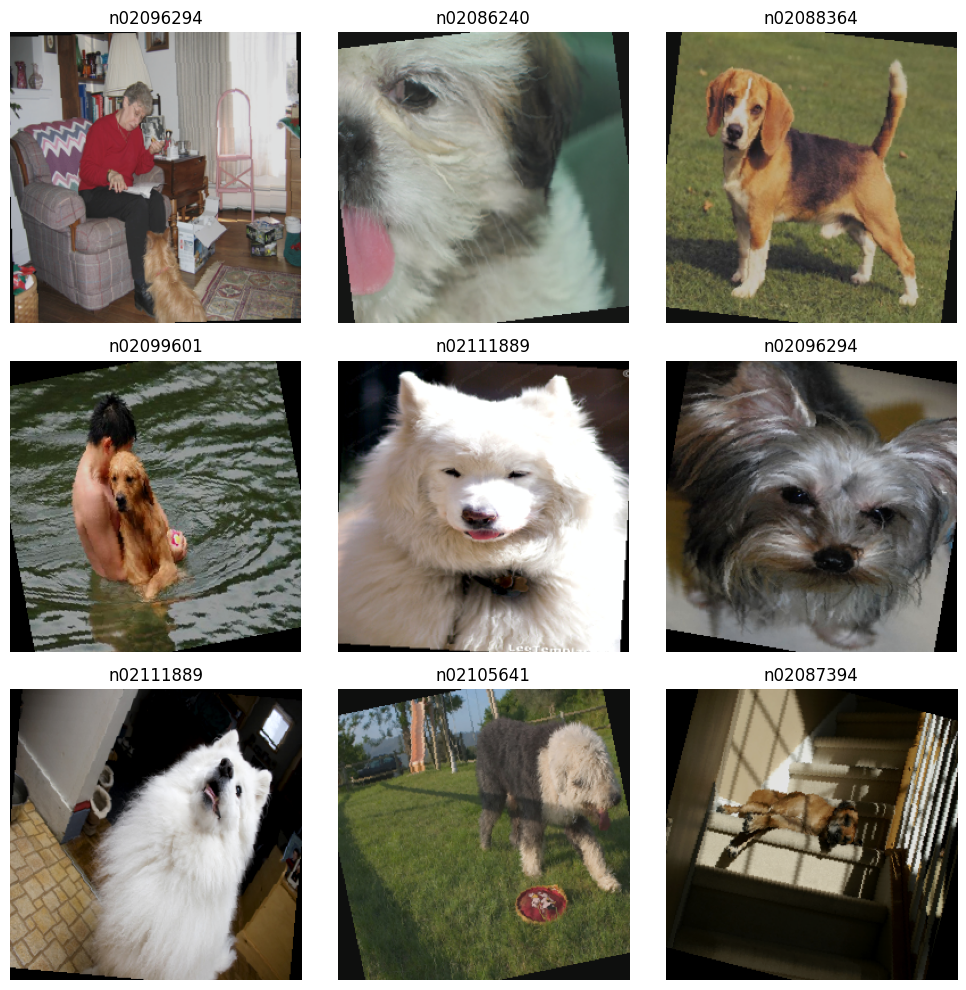

In [23]:
# Función para mostrar imágenes
def imshow(img, title=None):
	img = img.numpy().transpose((1, 2, 0))
	mean = np.array([0.485, 0.456, 0.406])
	std = np.array([0.229, 0.224, 0.225])
	img = std * img + mean  # desnormalizar
	img = np.clip(img, 0, 1)
	plt.imshow(img)
	if title is not None:
		plt.title(title)
	plt.axis('off')


# Mostrar un batch de entrenamiento
images, labels = next(iter(train_loader))

plt.figure(figsize=(10, 10))
for i in range(9):
	plt.subplot(3, 3, i + 1)
	imshow(images[i], title=train_dataset.classes[labels[i]])
plt.tight_layout()
plt.show()

# Arquitectura de la CNN -- TinyVGG

https://medium.com/bokchilab/optimizing-the-tinyvgg-model-for-cifar-10-classification-with-mlops-ee8a697eecb5

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class MiniVGG(nn.Module):
    def __init__(self, num_classes=10):
        super(MiniVGG, self).__init__()

        self.features = nn.Sequential(
            # Bloque 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1), # entrada 3 canales (RGB) a 32 canales
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Bloque 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Bloque 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Capa totalmente conectada
        self.classifier = nn.Sequential(
            nn.Linear(256 * 32 * 32, 512),  # ajustar según el tamaño de entrada
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Instanciar el modelo
model = MiniVGG(num_classes=10)

# Mover a GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

#print(model)

# Mostrar resumen del modelo
summary(model, (3, 256, 256))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

## Entrenamiento y Validacion

In [25]:
# Definir pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward + optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Métricas
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Entrenamiento principal
EPOCHS = 60

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    print(f"Epoch [{epoch+1}/{EPOCHS}] | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")


KeyboardInterrupt: 